In [33]:
import os
import cv2
import numpy as np
import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
# Dataset Directory
data_dir = "images\\train2"

In [3]:
# Classes
sub_folders = os.listdir(data_dir)

In [4]:
# Declaring the lists for images and labels
images = []
labels = []

In [5]:
# Accessing the labels
for sub_folder in sub_folders:
    label = sub_folder

    # Constructing the path to the current sub-folder
    path = os.path.join(data_dir, sub_folder)

    # Listing all images in the current sub-folder
    sub_folder_images = os.listdir(path)

    # Accessing the Images
    for image_name in sub_folder_images:
        # Constructing the path to the current image
        image_path = os.path.join(path, image_name)
        # Loading the image using OpenCV
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        # Appending the image to the list of images
        images.append(img)
        # Appending the label corresponding to the current sub-folder to the list of labels
        labels.append(label)

In [6]:
images = np.array(images)
labels = np.array(labels)
print(len(images))

11157


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42)

In [8]:
def preprocessing(img):
    img = img / 255.0
    img = cv2.resize(img, (48, 48))
    return img.reshape(-1, 48, 48, 1)

In [9]:
X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

In [10]:
X_train = X_train.reshape(-1, 48, 48, 1)
X_val = X_val.reshape(-1, 48, 48, 1)
X_test = X_test.reshape(-1, 48, 48, 1)

In [11]:
data_gen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    rotation_range=10
)

# Compute necessary statistics for data augmentation
data_gen.fit(X_train)

In [12]:
label_encoder = LabelEncoder()
label_encoder.fit(labels)

LabelEncoder()

In [13]:
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [14]:
num_classes = len(label_encoder.classes_)

# Convert encoded class labels to one-hot encoded categorical arrays
y_train_categorical = to_categorical(y_train, num_classes=num_classes)
y_val_categorical = to_categorical(y_val, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

In [15]:
def build_model():
    model = Sequential()
    # 1st Layer
    model.add(Conv2D(64, (5, 5), strides=(1, 1), padding='same', activation='relu', input_shape=(48, 48, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.3))

    # 2nd Layer
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.3))

    # 3rd layer
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.3))

    # 4th layer
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.3))

    # Flatten Layer
    model.add(Flatten())

    # Fully connected layer 1
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Fully connected layer 2
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compiling the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [16]:
model = build_model()

# Print model summary
print(model.summary())

C:\Users\memoc\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │             

 Total params: 4,346,114 (16.58 MB)

 Trainable params: 4,342,146 (16.56 MB)

 Non-trainable params: 3,968 (15.50 KB)

None


In [17]:
checkpoint = ModelCheckpoint("model.keras", monitor="val_acc", verbose=1, save_best_only=True)

In [18]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    restore_best_weights=True
)

In [19]:
# Initialize ReduceLROnPlateau callback
reduce_learningrate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_delta=0.0001
)

In [20]:
callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

In [21]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [22]:
history = model.fit(
    data_gen.flow(X_train, y_train_categorical, batch_size=128),
    validation_data=(X_val, y_val_categorical),
    epochs=50,
    verbose=1
)

Epoch 1/50


C:\Users\memoc\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 57s 841ms/step - accuracy: 0.5420 - loss: 0.9785 - val_accuracy: 0.6495 - val_loss: 0.7094
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 848ms/step - accuracy: 0.6045 - loss: 0.7690 - val_accuracy: 0.6495 - val_loss: 0.9181
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 864ms/step - accuracy: 0.6259 - loss: 0.6989 - val_accuracy: 0.6495 - val_loss: 0.9560
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 57s 896ms/step - accuracy: 0.6579 - loss: 0.6408 - val_accuracy: 0.6495 - val_loss: 0.9367
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 870ms/step - accuracy: 0.7150 - loss: 0.5616 - val_accuracy: 0.3505 - val_loss: 1.2867
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 861ms/step - accuracy: 0.7450 - loss: 0.5166 - val_accuracy: 0.6495 - val_loss: 1.0516
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 892ms/step - accuracy: 0.7700 - loss: 0.4761 - val_accuracy: 0.6506 - val_loss: 1.2000
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 61s 958ms/step - accuracy: 0.8033 - loss: 0.4346 - val_accuracy: 0.640

In [32]:
model.save('modelv1.h5')

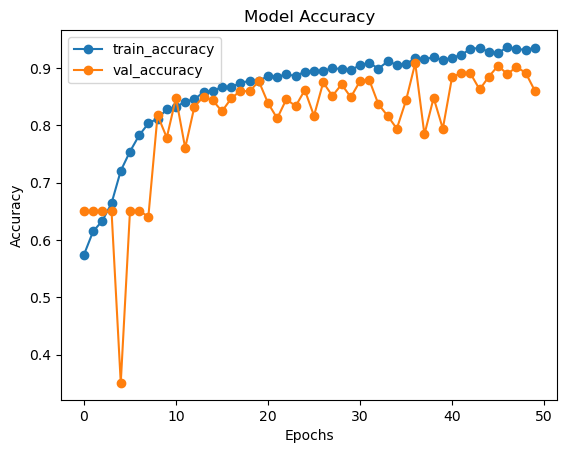

In [30]:
# Plotting model performance
plt.plot(history.history['accuracy'], label='train_accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='val_accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()